In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.2 MB/s eta 0:00:00:00:0100:01


In [8]:
# unet_water_seg.py
# Water Body Segmentation using U-Net on 12-band Multispectral Data

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import rasterio
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [19]:
# ======================================
# 1. CONFIGURATION
# ======================================
DATA_DIR = "/kaggle/input/satellite-dataset/data"
IMAGE_DIR = os.path.join(DATA_DIR, "images")
LABEL_DIR = os.path.join(DATA_DIR, "labels")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
BATCH_SIZE = 16
LR = 1e-4
IMG_SIZE = 128
NUM_BANDS = 12

MODEL_SAVE_PATH = "models/unet_water_seg.pth"
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [20]:
# ======================================
# 2. DATA LOADING & PREPROCESSING
# ======================================
def load_image(filepath):
    """Load 12-band .tif image"""
    with rasterio.open(filepath) as src:
        image = src.read()  # (bands, H, W)
    image = np.transpose(image, (1, 2, 0))  # (H, W, bands)
    return image.astype(np.float32)

def load_mask(filepath):
    """Load binary .png mask"""
    mask = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 128).astype(np.uint8)  # Ensure binary
    return mask

def normalize_image(image):
    """Normalize each band independently using Min-Max scaling"""
    normalized = np.zeros_like(image)
    scaler = MinMaxScaler()
    for i in range(image.shape[2]):
        band = image[:, :, i].flatten().reshape(-1, 1)
        normalized[:, :, i] = scaler.fit_transform(band).reshape(IMG_SIZE, IMG_SIZE)
    return normalized


In [21]:
# ======================================
# 3. CUSTOM DATASET
# ======================================
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
        self.label_names = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

        # Match filenames
        self.image_names = [f for f in self.image_names if f.replace('.tif', '.png') in self.label_names]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        label_name = img_name.replace('.tif', '.png')

        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, label_name)

        image = load_image(img_path)
        mask = load_mask(label_path)

        if self.transform:
            image = normalize_image(image)

        # To Tensor: (C, H, W)
        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)  # Use long for CE loss

        return image, mask


In [22]:
# ======================================
# 4. U-NET MODEL
# ======================================
class UNet(nn.Module):
    def __init__(self, in_channels=12, out_classes=1):
        super(UNet, self).__init__()
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = double_conv(in_channels, 64)
        self.enc2 = double_conv(64, 128)
        self.enc3 = double_conv(128, 256)
        self.enc4 = double_conv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = double_conv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = double_conv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = double_conv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = double_conv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = double_conv(128, 64)

        self.final = nn.Conv2d(64, out_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        return out


In [23]:
# ======================================
# 5. METRICS
# ======================================
def compute_iou(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred) > 0.5
    pred = pred.long()
    intersection = (pred & target).sum().float()
    union = (pred | target).sum().float()
    return (intersection + smooth) / (union + smooth)

def compute_precision_recall_f1(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred) > 0.5
    pred = pred.long()
    tp = (pred & target).sum().float()
    fp = (pred & (~target.bool())).sum().float()
    fn = ((~pred.bool()) & target).sum().float()

    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return precision, recall, f1



In [24]:
# ======================================
# 6. VISUALIZATION
# ======================================
def plot_bands(image, title="Multispectral Bands"):
    """Plot all 12 bands"""
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    axes = axes.ravel()
    for i in range(12):
        axes[i].imshow(image[:, :, i], cmap='gray')
        axes[i].set_title(f'Band {i+1}')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig("results/band_visualization.png")
    plt.show()

def plot_sample(image, mask, pred=None, title="Sample"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3 if pred is not None else 2, 1)
    plt.imshow(np.mean(image, axis=2), cmap='gray')
    plt.title("Input (Avg Bands)")
    plt.axis('off')

    plt.subplot(1, 3 if pred is not None else 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    if pred is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f"results/{title.lower().replace(' ', '_')}.png")
    plt.show()


In [25]:
# ======================================
# 7. TRAINING & EVALUATION
# ======================================
def train():
    # Dataset and DataLoader
    dataset = WaterDataset(IMAGE_DIR, LABEL_DIR)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")

    # Model, Loss, Optimizer
    model = UNet(in_channels=NUM_BANDS, out_classes=1).to(DEVICE)
    criterion_bce = nn.BCEWithLogitsLoss()
    criterion_dice = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Training loop
    train_losses = []
    val_ious = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images = images.to(DEVICE)  # (B, 12, 128, 128)
            masks = masks.unsqueeze(1).float().to(DEVICE)  # (B, 1, 128, 128)

            optimizer.zero_grad()
            outputs = model(images)
            loss_bce = criterion_bce(outputs, masks)
            loss_dice = criterion_dice(torch.sigmoid(outputs), masks)
            loss = 0.5 * loss_bce + 0.5 * loss_dice
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_iou = 0.0
        val_precision = 0.0
        val_recall = 0.0
        val_f1 = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(DEVICE)
                masks = masks.unsqueeze(1).long().to(DEVICE)
                outputs = model(images)
                val_iou += compute_iou(outputs, masks).item()
                p, r, f = compute_precision_recall_f1(outputs, masks)
                val_precision += p.item()
                val_recall += r.item()
                val_f1 += f.item()

        val_iou /= len(val_loader)
        val_precision /= len(val_loader)
        val_recall /= len(val_loader)
        val_f1 /= len(val_loader)
        val_ious.append(val_iou)

        print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | "
              f"IoU: {val_iou:.4f} | Prec: {val_precision:.4f} | Rec: {val_recall:.4f} | F1: {val_f1:.4f}")

        # Save best model
        if val_iou == max(val_ious):
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved to {MODEL_SAVE_PATH}")

    # Final plots
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot([i/len(val_loader) for i in range(EPOCHS)], label="Val IoU")
    plt.legend()
    plt.title("Training Loss & Validation IoU")
    plt.savefig("results/training_curve.png")
    plt.show()

    return model


In [26]:
# Additional: Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()



In [27]:
# ======================================
# 8. INFERENCE & VISUALIZE
# ======================================
def evaluate_and_visualize(model):
    dataset = WaterDataset(IMAGE_DIR, LABEL_DIR)
    model.eval()
    model.to(DEVICE)

    with torch.no_grad():
        for i in range(5):  # Show 5 samples
            image, mask = dataset[i]
            image_tensor = image.unsqueeze(0).to(DEVICE)

            output = model(image_tensor)
            pred_mask = torch.sigmoid(output).cpu().squeeze().numpy() > 0.5

            img_np = image.numpy().transpose(1, 2, 0)  # (H, W, C)
            mask_np = mask.numpy()

            plot_sample(img_np, mask_np, pred_mask, title=f"Sample {i+1}")


Using device: cuda


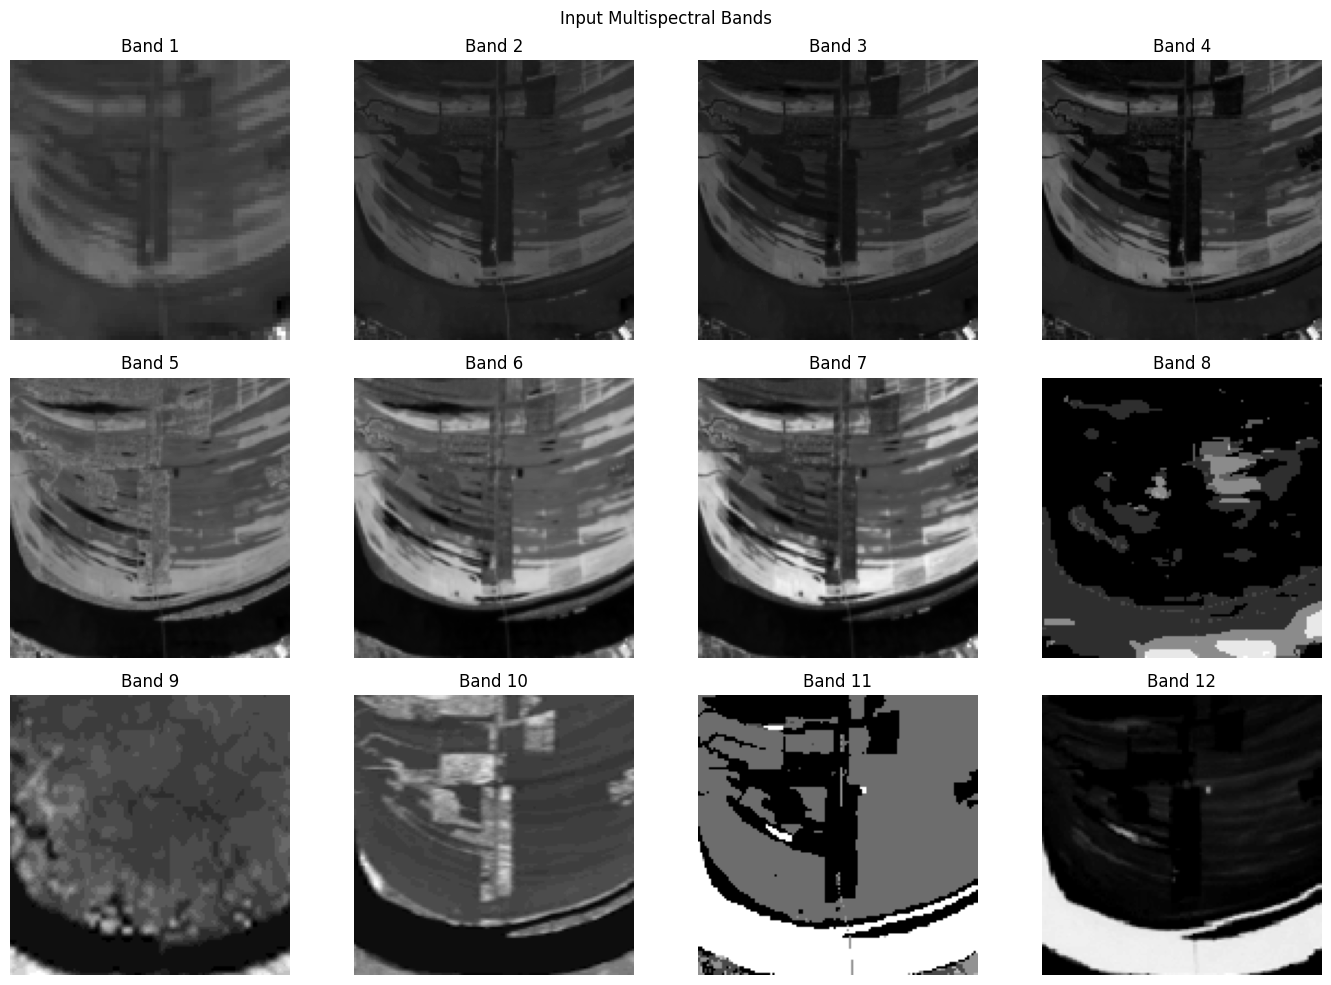

Training samples: 244, Validation samples: 62


Epoch 1/50: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Epoch 1 | Loss: 0.8945 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000
Model saved to models/unet_water_seg.pth


Epoch 2/50: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


Epoch 2 | Loss: 0.7945 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000
Model saved to models/unet_water_seg.pth


Epoch 3/50: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


Epoch 3 | Loss: 0.7484 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000
Model saved to models/unet_water_seg.pth


Epoch 4/50: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 4 | Loss: 0.7308 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000
Model saved to models/unet_water_seg.pth


Epoch 5/50: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 5 | Loss: 0.7197 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000


Epoch 6/50: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


Epoch 6 | Loss: 0.7128 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000


Epoch 7/50: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 7 | Loss: 0.7087 | IoU: 0.7500 | Prec: 0.7500 | Rec: 1.0000 | F1: 0.7500
Model saved to models/unet_water_seg.pth


Epoch 8/50: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


Epoch 8 | Loss: 0.7005 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000


Epoch 9/50: 100%|██████████| 16/16 [00:04<00:00,  3.20it/s]


Epoch 9 | Loss: 0.6936 | IoU: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.5000


Epoch 10/50: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 10 | Loss: 0.6902 | IoU: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.5000


Epoch 11/50: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 11 | Loss: 0.6837 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000


Epoch 12/50: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 12 | Loss: 0.6775 | IoU: 0.2500 | Prec: 0.2500 | Rec: 1.0000 | F1: 0.2500


Epoch 13/50: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 13 | Loss: 0.6721 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 14/50: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 14 | Loss: 0.6669 | IoU: 0.2500 | Prec: 0.2500 | Rec: 1.0000 | F1: 0.2500


Epoch 15/50: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 15 | Loss: 0.6619 | IoU: 0.2500 | Prec: 0.2500 | Rec: 1.0000 | F1: 0.2500


Epoch 16/50: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 16 | Loss: 0.6575 | IoU: 0.2500 | Prec: 0.2500 | Rec: 1.0000 | F1: 0.2500


Epoch 17/50: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 17 | Loss: 0.6533 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000


Epoch 18/50: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 18 | Loss: 0.6520 | IoU: 0.2500 | Prec: 0.2500 | Rec: 1.0000 | F1: 0.2500


Epoch 19/50: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 19 | Loss: 0.6464 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 20/50: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 20 | Loss: 0.6419 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 21/50: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 21 | Loss: 0.6378 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 22/50: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 22 | Loss: 0.6344 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 23/50: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 23 | Loss: 0.6310 | IoU: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.5000


Epoch 24/50: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


Epoch 24 | Loss: 0.6273 | IoU: 0.7500 | Prec: 0.7500 | Rec: 1.0000 | F1: 0.7500


Epoch 25/50: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


Epoch 25 | Loss: 0.6245 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 26/50: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 26 | Loss: 0.6217 | IoU: 0.7500 | Prec: 0.7500 | Rec: 1.0000 | F1: 0.7500


Epoch 27/50: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 27 | Loss: 0.6187 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000


Epoch 28/50: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 28 | Loss: 0.6158 | IoU: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.5000


Epoch 29/50: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 29 | Loss: 0.6130 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 30/50: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 30 | Loss: 0.6102 | IoU: 0.7500 | Prec: 0.7500 | Rec: 1.0000 | F1: 0.7500


Epoch 31/50: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 31 | Loss: 0.6074 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 32/50: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 32 | Loss: 0.6048 | IoU: 0.7500 | Prec: 0.7500 | Rec: 1.0000 | F1: 0.7500


Epoch 33/50: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 33 | Loss: 0.6028 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 34/50: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]


Epoch 34 | Loss: 0.6000 | IoU: 0.7500 | Prec: 0.7500 | Rec: 1.0000 | F1: 0.7500


Epoch 35/50: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]


Epoch 35 | Loss: 0.5978 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 36/50: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


Epoch 36 | Loss: 0.5956 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 37/50: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 37 | Loss: 0.5934 | IoU: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.5000


Epoch 38/50: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


Epoch 38 | Loss: 0.5909 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 39/50: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]


Epoch 39 | Loss: 0.5887 | IoU: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.5000


Epoch 40/50: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


Epoch 40 | Loss: 0.5866 | IoU: 0.7500 | Prec: 0.7500 | Rec: 1.0000 | F1: 0.7500


Epoch 41/50: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 41 | Loss: 0.5846 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 42/50: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


Epoch 42 | Loss: 0.5828 | IoU: 0.7500 | Prec: 0.7500 | Rec: 1.0000 | F1: 0.7500


Epoch 43/50: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


Epoch 43 | Loss: 0.5811 | IoU: 0.0000 | Prec: 0.0000 | Rec: 1.0000 | F1: 0.0000


Epoch 44/50: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]


Epoch 44 | Loss: 0.5798 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 45/50: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]


Epoch 45 | Loss: 0.5777 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 46/50: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]


Epoch 46 | Loss: 0.5757 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 47/50: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 47 | Loss: 0.5739 | IoU: 0.7500 | Prec: 0.7500 | Rec: 1.0000 | F1: 0.7500


Epoch 48/50: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 48 | Loss: 0.5723 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 49/50: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 49 | Loss: 0.5707 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


Epoch 50/50: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 50 | Loss: 0.5690 | IoU: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Model saved to models/unet_water_seg.pth


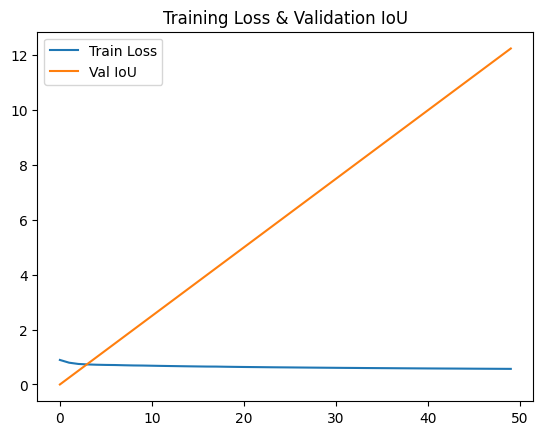

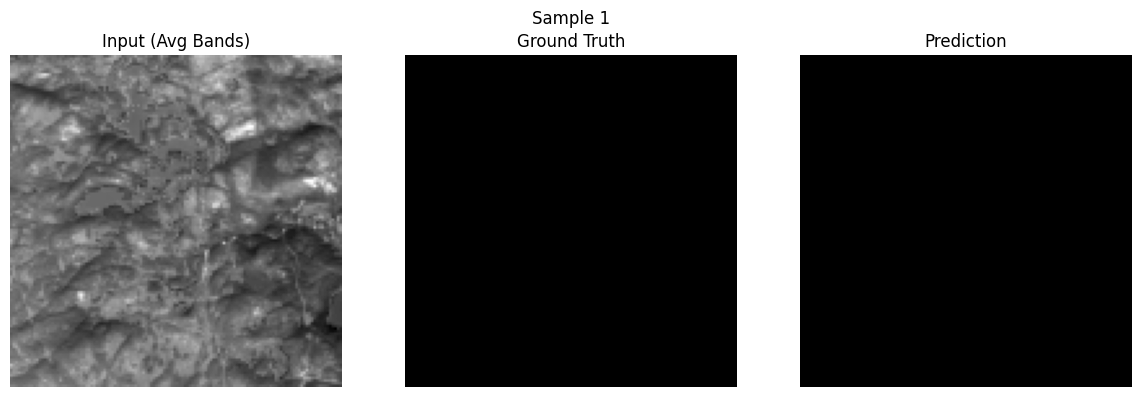

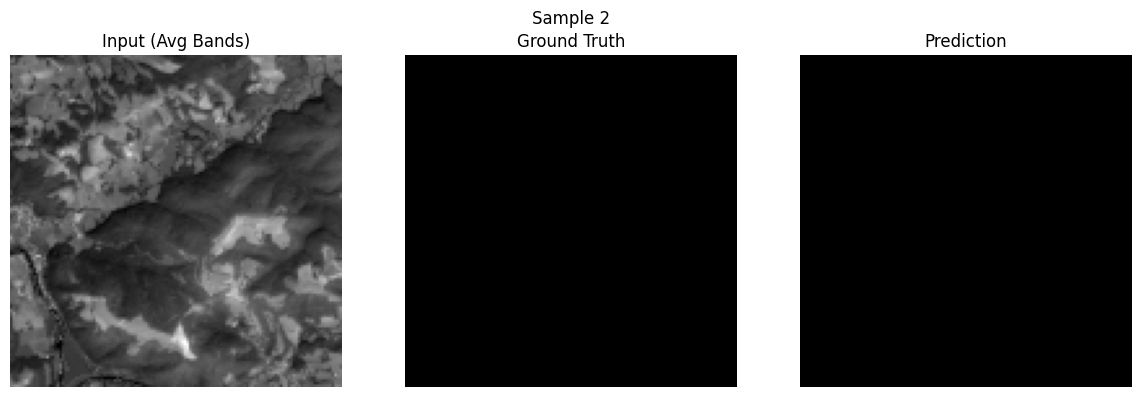

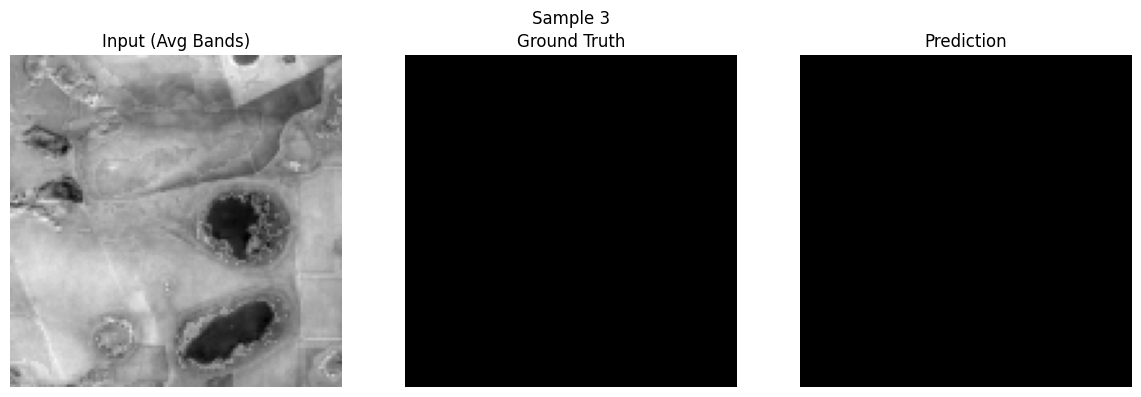

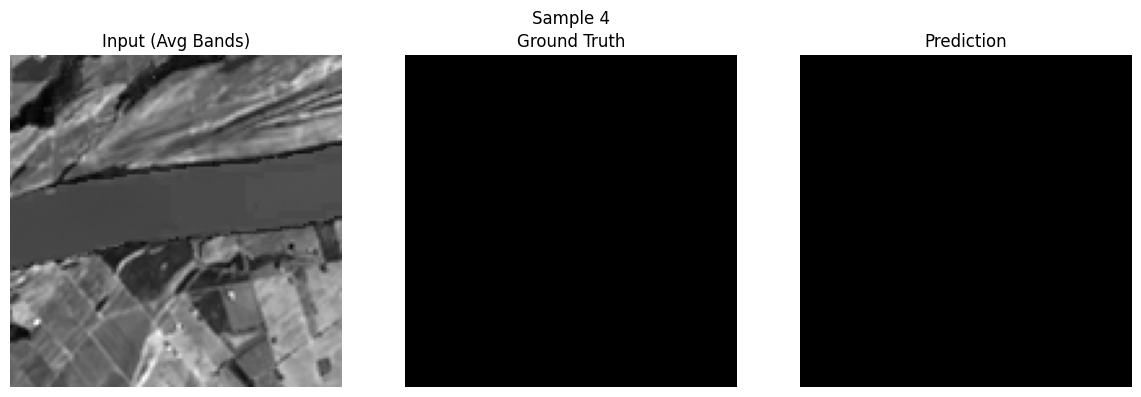

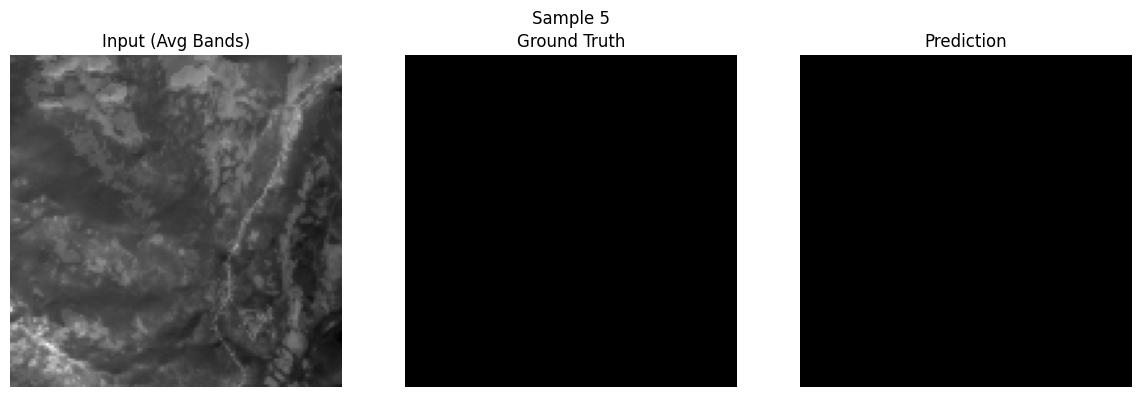

✅ Training completed. Check 'results/' for outputs.


In [28]:
# ======================================
# 9. MAIN EXECUTION
# ======================================
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")

    # Step 1: Load one sample to visualize bands
    sample_img_path = os.path.join(IMAGE_DIR, os.listdir(IMAGE_DIR)[0])
    sample_img = load_image(sample_img_path)
    plot_bands(sample_img, "Input Multispectral Bands")

    # Step 2: Train the model
    model = train()

    # Step 3: Load best model and evaluate
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    evaluate_and_visualize(model)

    print("✅ Training completed. Check 'results/' for outputs.")